In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
theano.config.gcc__cxxflags += " -fexceptions"
theano.config.on_opt_error = "raise"
theano.tensor.opt.constant_folding
theano.graph.opt.EquilibriumOptimizer
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
from tqdm import tqdm
from theano.tensor.random.utils import RandomStream
import scipy.linalg as sl
import scipy.stats as ss
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import lightkurve as lk

starry.config.quiet = True
np.random.seed(1)

%matplotlib inline

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import StarryStarryProcess as ssp

# Preparing the data.
Let's download and work with only the quarter 6 of the Kepler data.

In [3]:
search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short', quarter=6)
# Download all available Kepler light curves
lc_collection_q6 = search_result.download_all()

search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()

This is  the quarter 6:

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

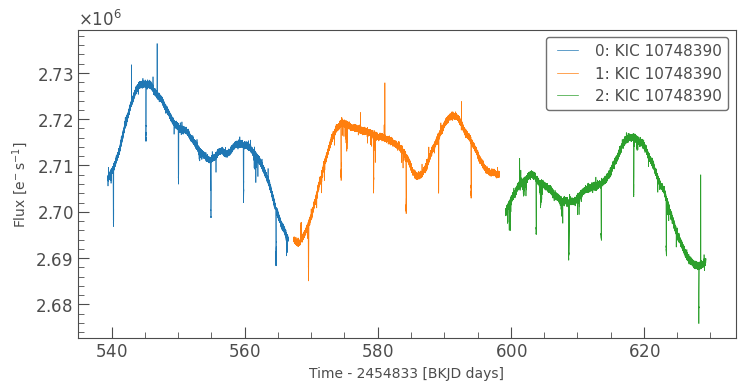

In [4]:
lc_collection_q6.plot()

In [5]:
all_lc = lc_collection.stitch()
lc_q6 = lc_collection_q6.stitch()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

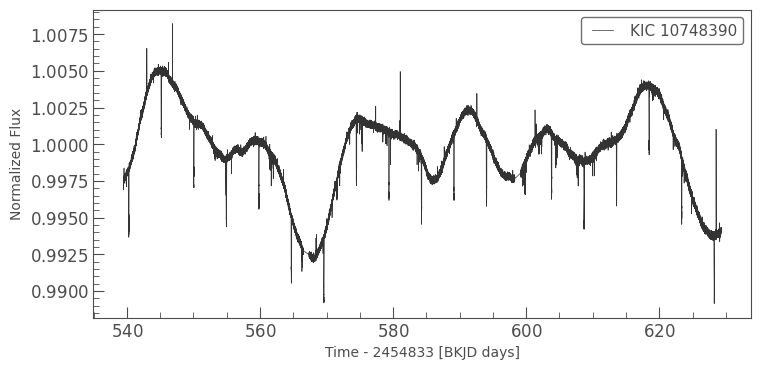

In [6]:
lc_q6.plot()

In [7]:
all_lc=all_lc.remove_nans()
lc_q6 = lc_q6.remove_nans()

In [8]:
all_lc = all_lc[all_lc.quality==0]
lc_q6 = lc_q6[lc_q6.quality == 0]

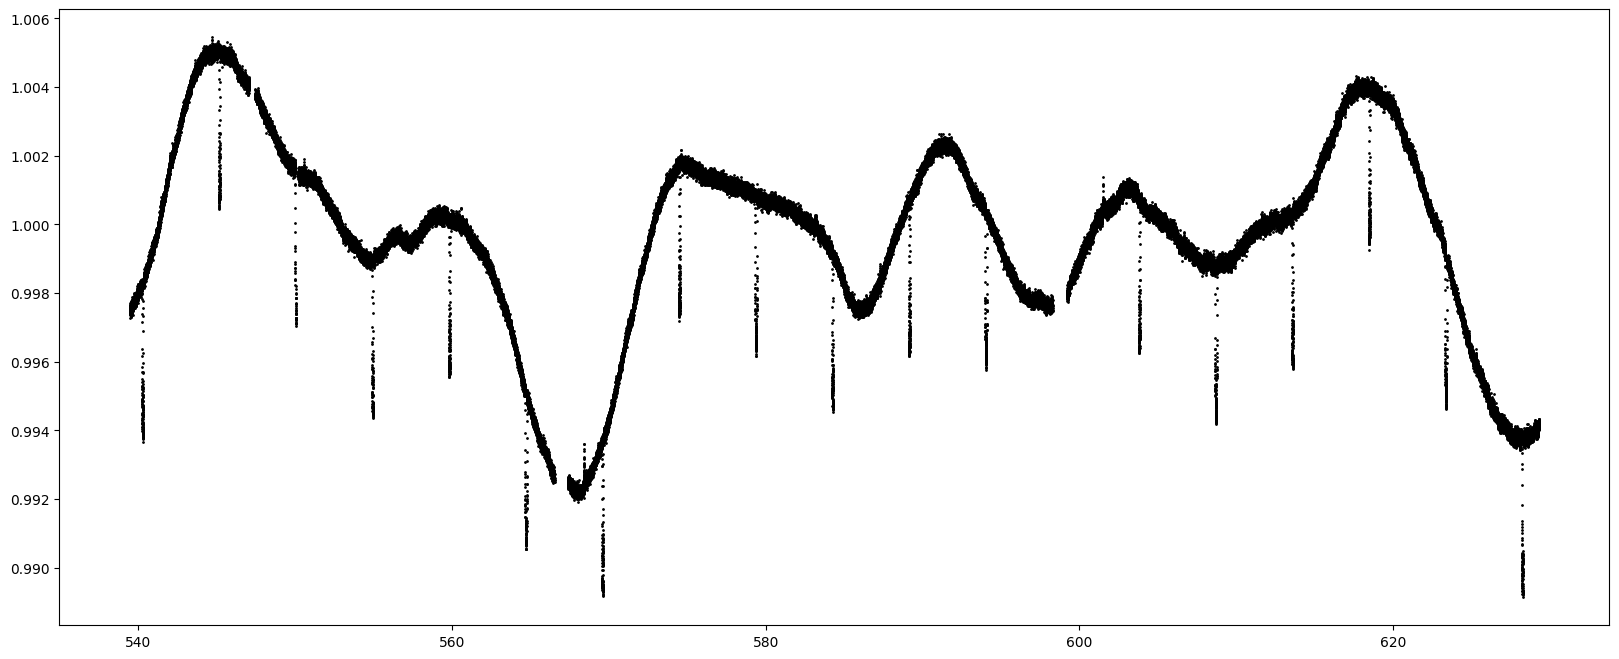

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(lc_q6.time.value, lc_q6.flux, "k.", ms=2)

(560.0, 580.0)

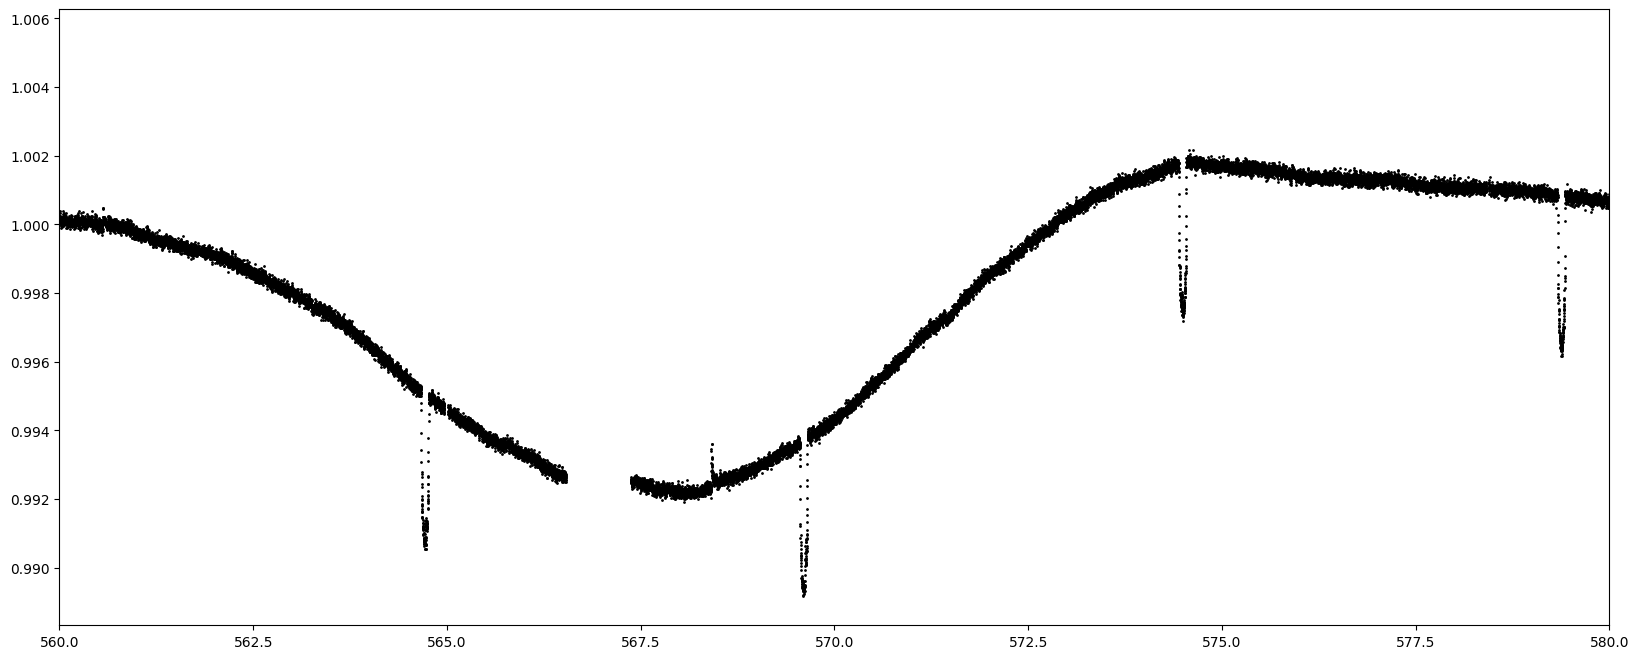

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(lc_q6.time.value, lc_q6.flux, "k.", ms=2)
plt.xlim(560,580)

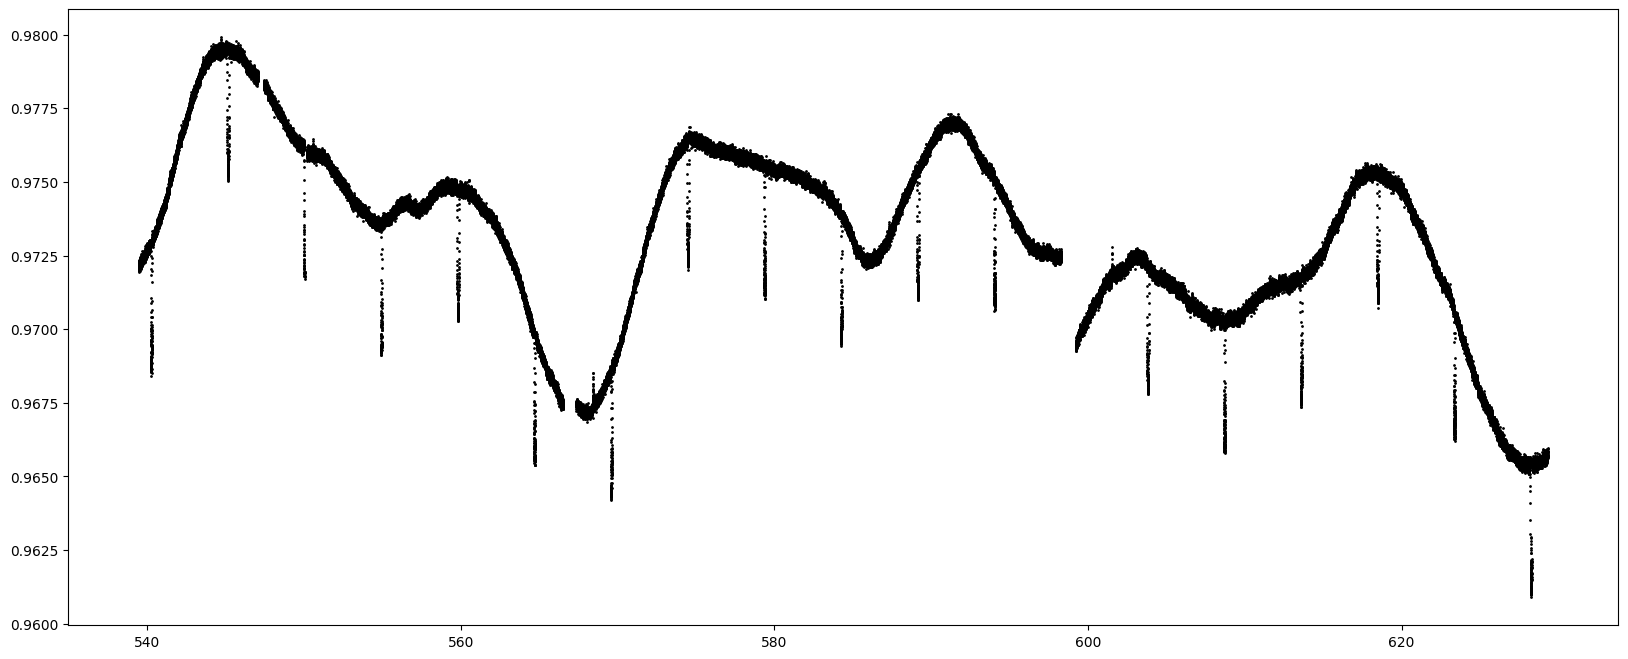

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(lc_q6.time.value, lc_q6.pdcsap_flux/np.mean(all_lc.pdcsap_flux), "k.", ms=2)

In [12]:
# time = all_lc.time.value[((all_lc.time.value>=808) * (all_lc.time.value<=906))]
time = lc_q6.time.value #saving the times

In [13]:
# flux = all_lc.pdcsap_flux[((all_lc.time.value>=808) & (all_lc.time.value<=906))]
flux = np.array(lc_q6.pdcsap_flux.value) # saving the fluxes with PDCSAP

In [14]:
mean_flux = np.mean(np.array(all_lc.pdcsap_flux.value))

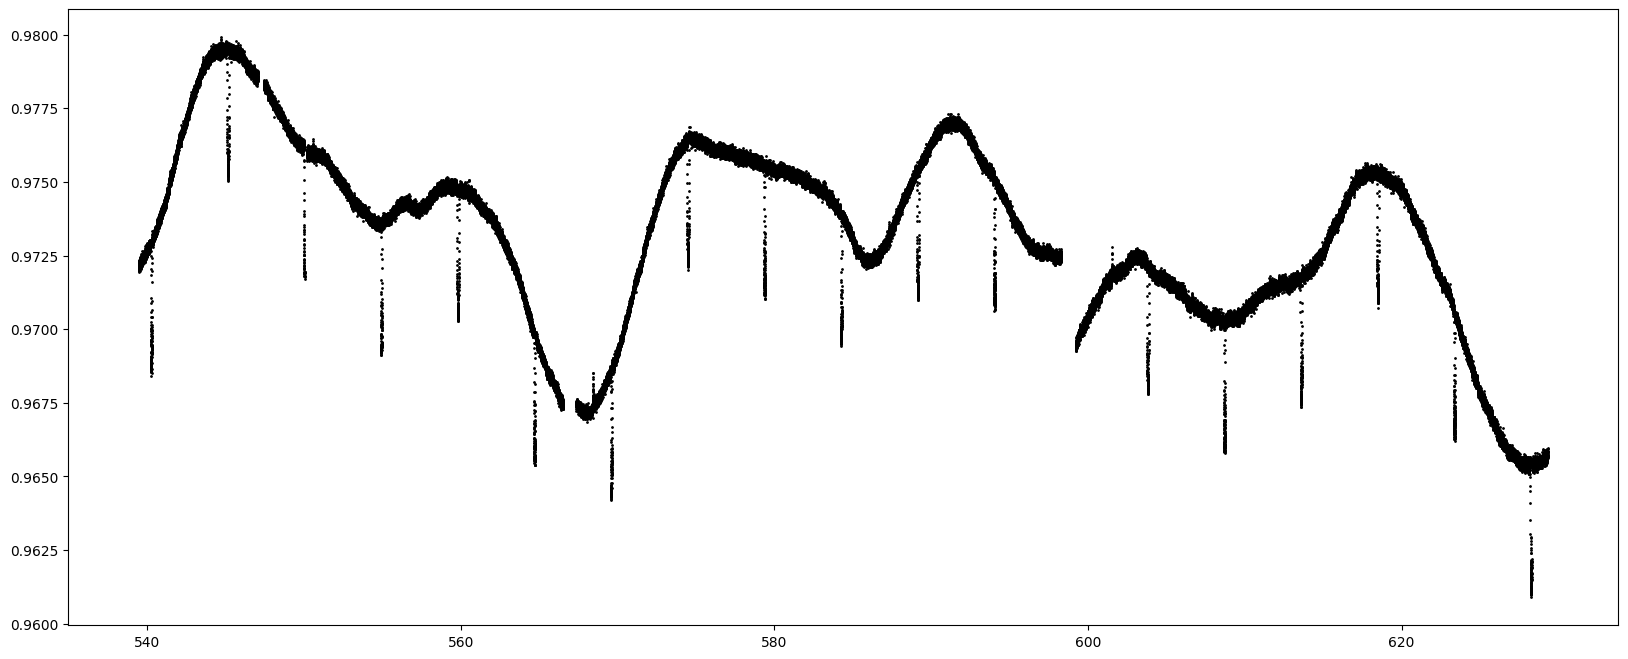

In [15]:
plt.figure(figsize=(20, 8))
plt.plot(time, flux/mean_flux, "k.", ms=2)

In [16]:
flux_obs = flux / mean_flux

(564.0, 566.0)

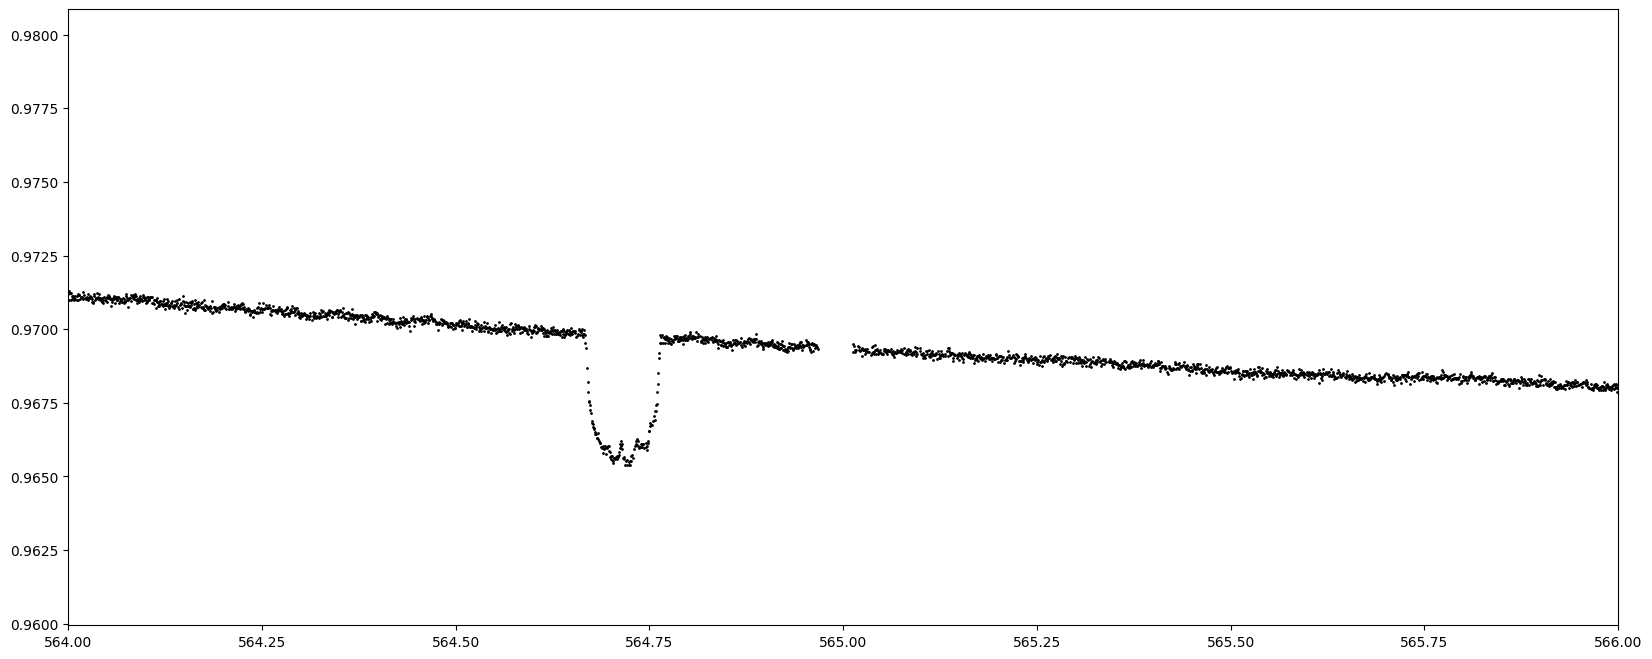

In [17]:
plt.figure(figsize=(20, 8))
plt.plot(time, flux/mean_flux, "k.", ms=2)
plt.xlim(564,566)

In [18]:
err = np.array(lc_q6.pdcsap_flux_err.value) / mean_flux

It turns out the times in Kepler data are not sorted properly in increasing order. Let's fix this by resorting the times and the fluxes that correspond to each value. 

In [20]:
times = [3.5, 1.2, 2.0, 4.8]
fluxes = [10.2, 5.6, 7.1, 12.3]

data = list(zip(times, fluxes))

sorted_data = sorted(data, key=lambda x: x[0])

sorted_times, sorted_fluxes = zip(*sorted_data)

print("Sorted Times:", sorted_times)
print("Sorted Fluxes:", sorted_fluxes)

Sorted Times: (1.2, 2.0, 3.5, 4.8)
Sorted Fluxes: (5.6, 7.1, 10.2, 12.3)


In [21]:
data = list(zip(time, flux_obs, err))

sorted_data = sorted(data, key=lambda x: x[0])

sorted_times, sorted_fluxes, sorted_errors = zip(*sorted_data)

In [22]:
time = np.array(sorted_times)
flux_obs = np.array(sorted_fluxes)
err = np.array(sorted_errors)

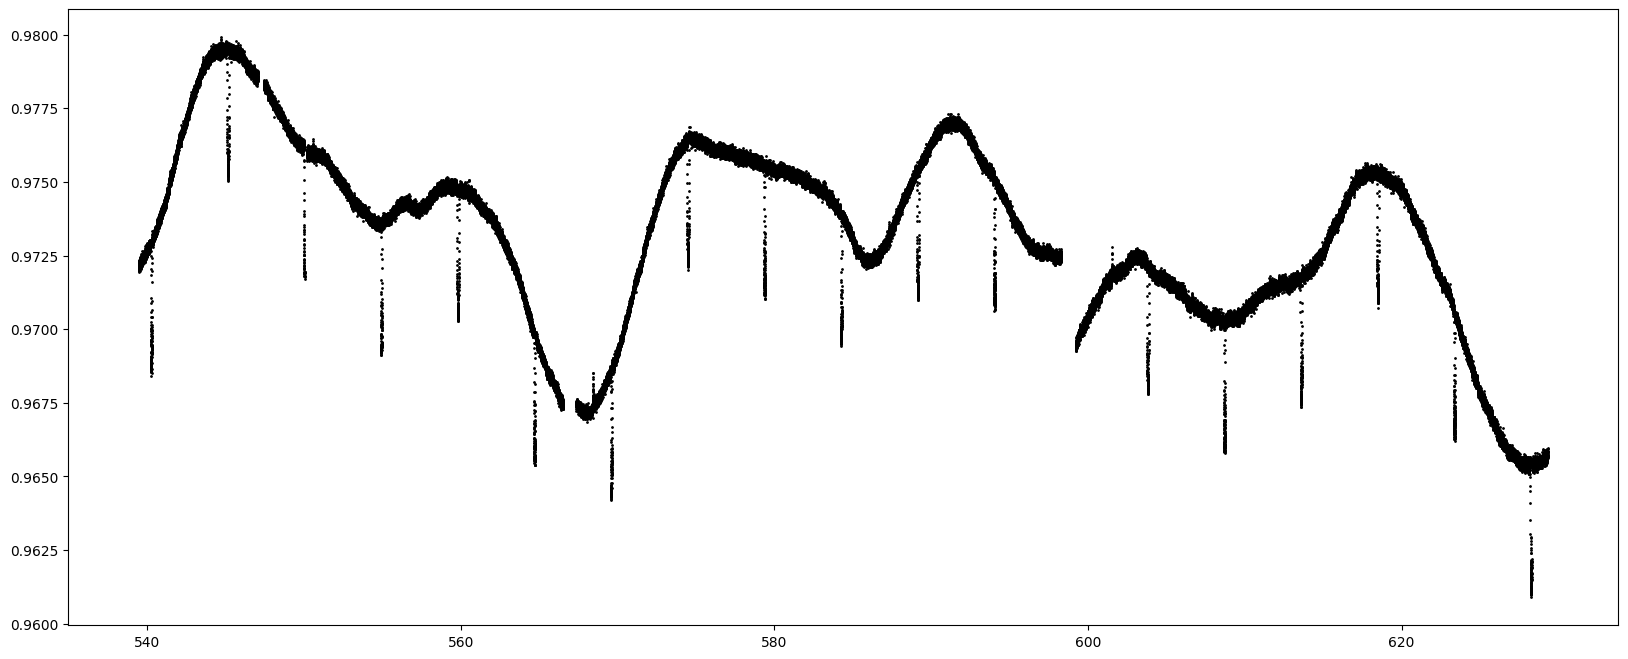

In [23]:
plt.figure(figsize=(20, 8))
plt.plot(time, flux_obs, "k.", ms=2)

In [24]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)

def ori_xyz(name, testval):
    stellar_ori_x = pm.Normal(name+'_ori_x', mu=0, sigma=1, testval=testval)
    stellar_ori_y = pm.Normal(name+'_ori_y', mu=0, sigma=1, testval=testval)
    stellar_ori_z = pm.Normal(name+'_ori_z', mu=0, sigma=1, testval=testval)

    return stellar_ori_x, stellar_ori_y, stellar_ori_z

def Planet_Inc(name, *args, **kwargs):
    bmax = params[name].get('bmax')
    b = pm.Uniform('b', -bmax, bmax)
    planet_inc = pm.Deterministic(name, 180.0/np.pi*np.arccos(b))
    
    return planet_inc

def Stellar_Ang(name, *args, **kwargs):
    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]
    stellar_ori_x, stellar_ori_y, stellar_ori_z = ori_xyz(name, trueval)

    if "inc" in name:
        return pm.Deterministic(name, 180.0/np.pi*tt.arccos(stellar_ori_z / tt.sqrt(tt.square(stellar_ori_x) + tt.square(stellar_ori_y) + tt.square(stellar_ori_z))))
    
    elif "obl" in name:
        return pm.Deterministic(name, 180.0/np.pi*tt.arctan2(stellar_ori_y, stellar_ori_x))

def Period(name, *args, **kwargs):
    frac_bounds = params[name].get('frac_bounds')

    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]

    def logp(trueval, frac_bounds):
        return pm.Uniform(name+'logp',tt.log(trueval) + np.log1p(-frac_bounds), tt.log(trueval) + np.log1p(frac_bounds))

    period = pm.Deterministic(name, tt.exp(logp(trueval, frac_bounds)))

    return period

def Logarithmic(name, *args, **kwargs):
    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]
    log_rp = pm.Uniform(name+'log', tt.log(trueval/2), tt.log(2*trueval))
    rp = pm.Deterministic(name, tt.exp(log_rp))

    return rp

# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [25]:
mSun = 1.989e33 # grams
mJ = 1.898e30 
rJ = 6.99e6 # cm
rSun = 69.634e6

In [26]:
mHATP11b = 0.0736 * mJ # grams
mHATP11 = 0.809 * mSun
rHATP11b = 0.389 * rJ # cm
rHATP11 = 0.683 * rSun 

In [28]:
# True parameters & priors
params = {
    "planet.inc": {"truth": 89.05, "dist": Planet_Inc},
    "planet.ecc": {"truth": 0.265, "dist": Uniform, "args": [0.0, 0.9]},
    "planet.Omega": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 4.888, "dist": Period},
    "planet.t0": {"truth": 124.82, "dist": Uniform, "args": [123, 125]},
    "planet.r": {"truth": rHATP11b / rSun, "dist": Logarithmic}, # in solar radii
    "planet.m": {"truth": mHATP11b / mSun, "dist": Uniform, "args": [7e-6, 7e-4]}, # in solar masses

    "star.inc": {"truth": 90, "dist": Stellar_Ang},
    "star.m": {"truth": mHATP11 / mSun, "dist": Uniform, "args": [0.5, 1.]},
    "star.u1": {"truth": 0.646, "dist": Uniform, "args": [0.5, 0.7]},
    "star.u2": {"truth": 0.048, "dist": Uniform, "args": [0.01, 0.05]},
    "star.prot": {"truth": 35, "dist": Uniform, "args": [10, 40]},
    "star.obl": {"truth": -106, "dist": Stellar_Ang},
    "star.r": {"truth": rHATP11 / rSun, "dist": Uniform, "args": [0.5, 1.]},

    "gp.r": {"truth": 20, "dist": Uniform, "args": [1.0, 30.0]},
    "gp.dr": {"truth": 5.0, "dist": Uniform, "args": [1.0, 10.0]},
    "gp.c": {"truth": 0.5, "dist": Uniform, "args": [0.01, 1]},
    "gp.n": {"truth": 10, "dist": Uniform, "args": [0, 50]},
    "gp.mu": {"truth": 30, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 5, "dist": Uniform, "args": [1.0, 10]}
}

In [77]:
def bin_out_of_transit(t, flux, err, params, dt=0.06, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

In [171]:
t_, flux_, err_ = bin_out_of_transit(time, flux_obs, err, params, dt=0.06, binsize=300)

In [172]:
t_.shape

(2976,)

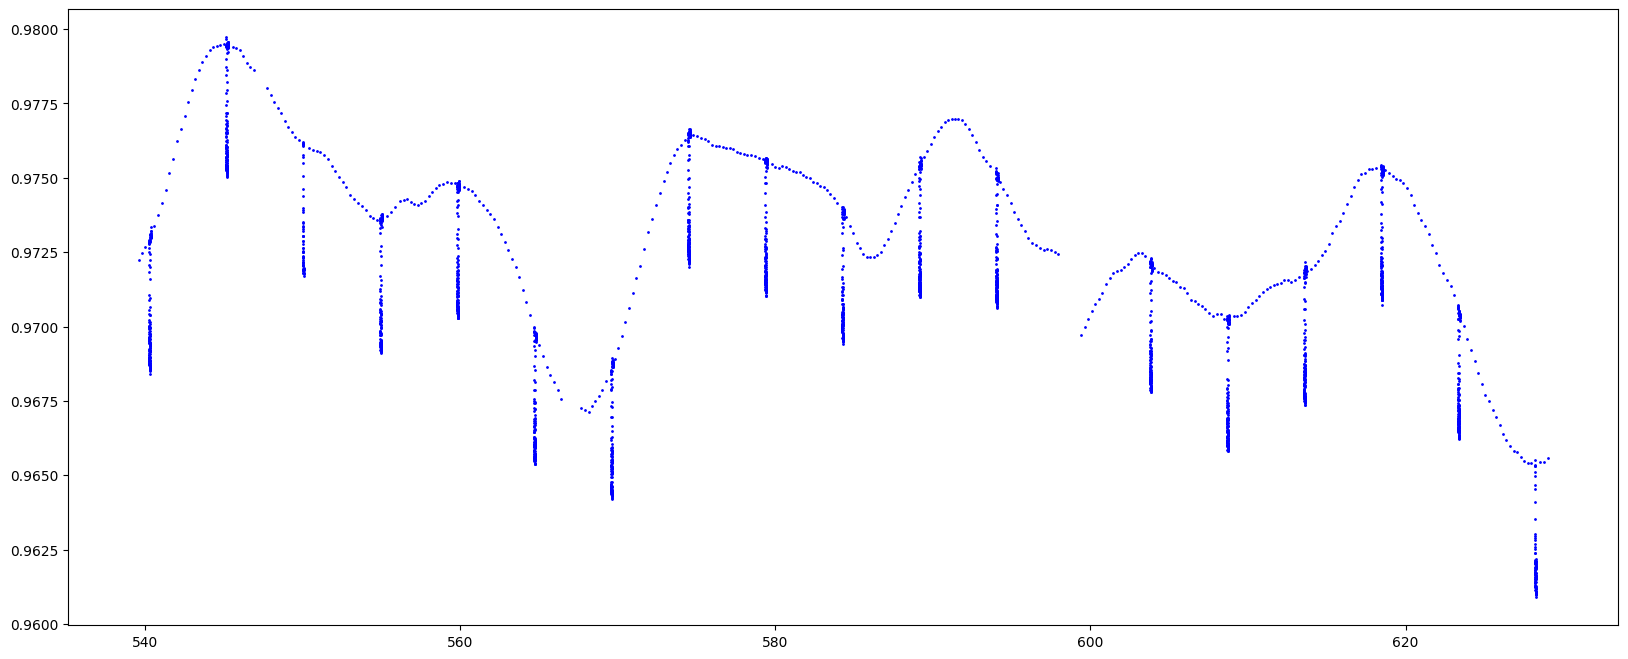

In [173]:
plt.figure(figsize=(20, 8))
# plt.plot(time, flux_obs, "k.", ms=2)
plt.plot(t_, flux_, 'b.', ms=2)
# plt.xlim(564,566)

(564.0, 580.0)

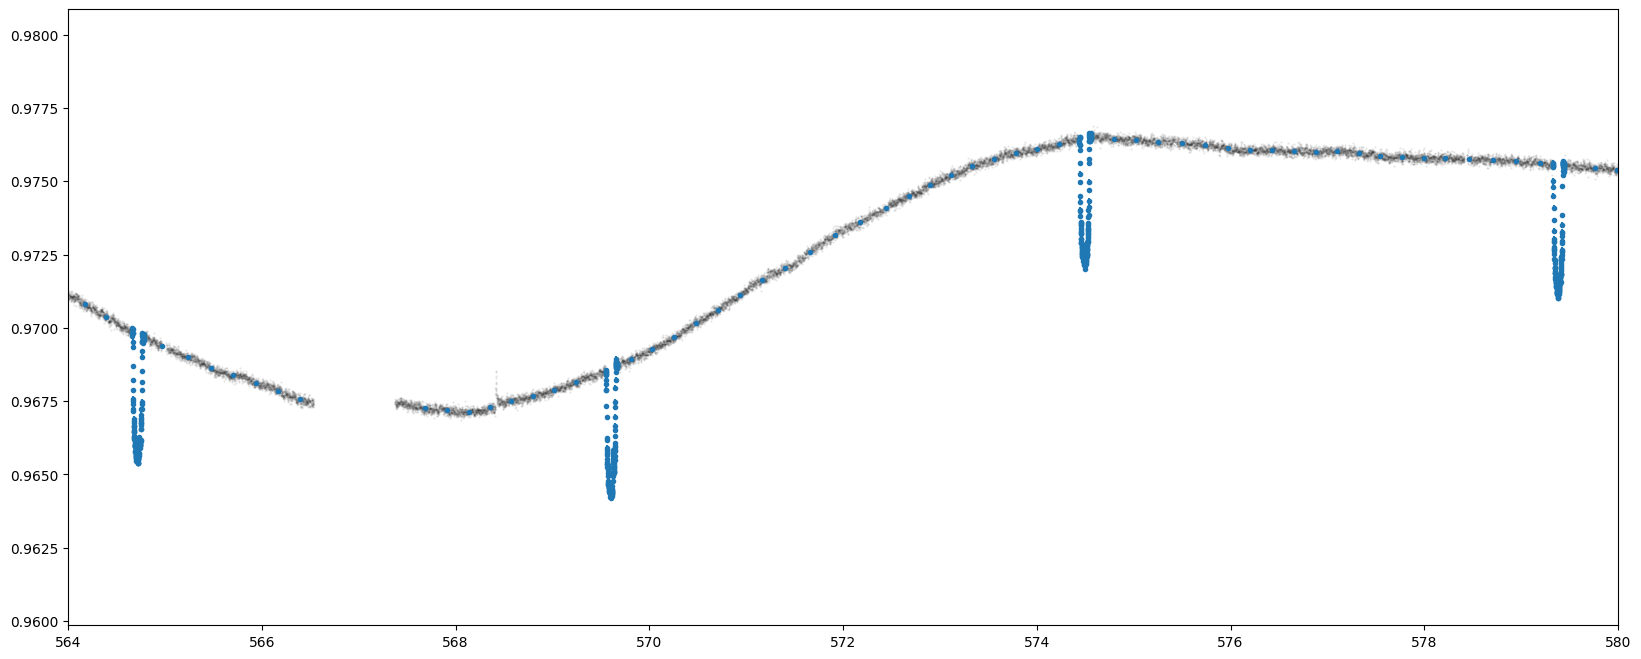

In [174]:
plt.figure(figsize=(20, 8))
plt.plot(time, flux_obs, "k.", ms=1, alpha=0.1)
plt.errorbar(t_, flux_,yerr=err_, fmt='.')
plt.xlim(564,580)

In [175]:
dt = 0.6
idx = np.zeros(len(t_), dtype=bool)
ntransits = int(np.ceil(t_[-1] / params["planet.porb"]["truth"]))
for n in range(ntransits):
    t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
    idx |= ((t_ > t0 - dt) & (t_ < t0 + dt))
t_in = t_[idx]
t_out = t_[~idx]
flux_in = flux_[idx]
flux_out = flux_[~idx]

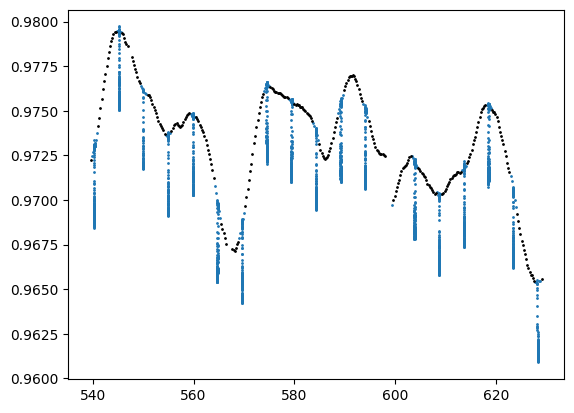

In [176]:
plt.plot(t_in, flux_in, '.', ms=2)
plt.plot(t_out, flux_out, 'k.', ms=2)

In [177]:
t_out[1] - t_out[0]

1.4841458482815142

In [178]:
# Setting the priors
# fraction bounds for period priors
Ttotal = t_[-1] - t_[0]
prot_frac_bounds = min(params['star.prot']['truth']/Ttotal/2, 0.25)
porb_frac_bounds = min(params['planet.porb']['truth']/Ttotal/2, 0.25)

# Let's add this parameter to the parameter dictionary as a prior
params['star.prot']['frac_bounds'] = prot_frac_bounds
params['planet.porb']['frac_bounds'] = porb_frac_bounds

# semi-major axis
a = (params['star.m']['truth']*np.square(params['planet.porb']['truth']/365.25))**(1/3) * 215.03 # Solar radii
# impact parameter
bmax = params['star.r']['truth'] / a

# Let's add this parameter to the parameter dictionary as a prior
params['planet.inc']['bmax'] = bmax

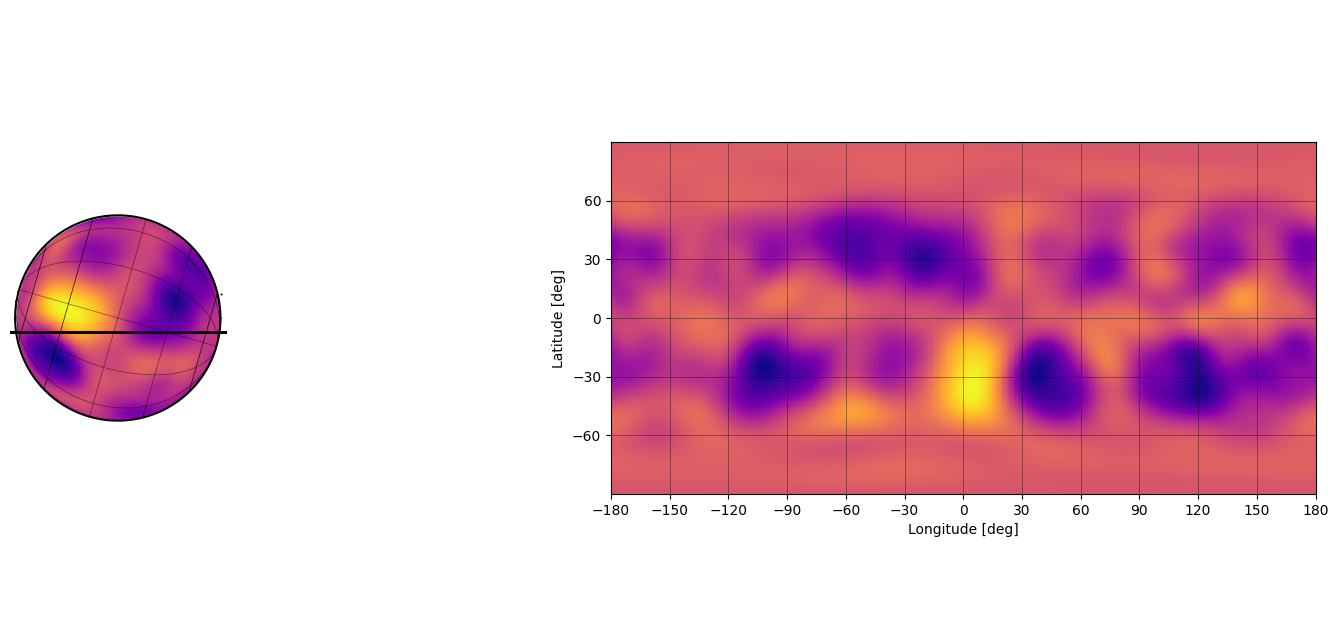

In [180]:
map = starry.Map(15, 2)
map.inc = params["star.inc"]["truth"]
map.obl = params["star.obl"]["truth"]
map[1] = params["star.u1"]["truth"]
map[2] = params["star.u2"]["truth"]
star = starry.Primary(map, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]["truth"]) 
planet = starry.Secondary(
    starry.Map(0,0),
    inc=params["planet.inc"]["truth"],
    ecc=params["planet.ecc"]["truth"],
    Omega=params["planet.Omega"]["truth"],
    porb=params["planet.porb"]["truth"],
    t0=params["planet.t0"]["truth"],
    r=params["planet.r"]["truth"],
    m=params["planet.m"]["truth"],
)

sys = starry.System(star, planet)
xo, yo, zo = sys.position(t_)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]
theta = (360 * t_ / params["star.prot"]["truth"]) % 360

# *** Draw 1 sample from the GP
sp = StarryProcess(
    mu=params["gp.mu"]["truth"],
    sigma=params["gp.sigma"]["truth"],
    r=params["gp.r"]["truth"],
    dr=params["gp.dr"]["truth"],
    c=params["gp.c"]["truth"],
    n=params["gp.n"]["truth"],
)

nt = len(t_)
SSP = ssp.StarryStarryProcess(sys, sp, nt, 256)

y_true = sp.sample_ylm().eval().reshape(-1)
y_true[0] += 1

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
ax[0].set_aspect(1)
ax[0].axis("off")
map[:, :] = y_true
map.show(ax=ax[0])
ax[0].set_ylim(-3, 3)
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
lat = 180 / np.pi * np.arcsin(yo[idx])
lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon = (lon + 180) % 360 - 180
mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
mask[mask == 1] = np.nan
map.show(ax=ax[1], projection="rect")
ax[1].plot(lon, lat + mask, "k-");
    

In [181]:
ylm_draw = SSP.sample_ylm_conditional(t_, flux_, err_).eval()[0,:]

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


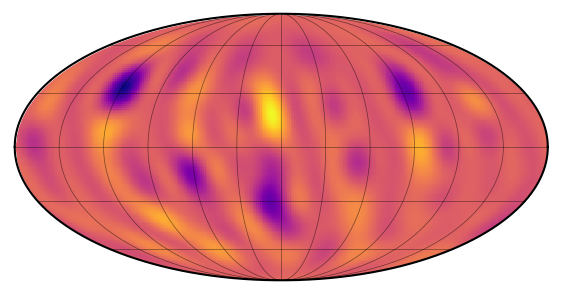

In [182]:
sp.visualize(ylm_draw)

In [183]:
SSP.marginal_likelihood(t_,flux_,err_).eval()

array(-43565182.67882776)

# Let's fit!

In [184]:
def gp_model(t, flux, err, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
            
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        prot = parameter('star.prot')
        stellar_inc = parameter('star.inc')
        stellar_obl = parameter('star.obl')

        porb = parameter('planet.porb')
        t0 = parameter('planet.t0')
        rp = parameter('planet.r')
        planet_inc = parameter('planet.inc')
        mp = parameter('planet.m')
        ecc = parameter('planet.ecc')
        Omega = parameter('planet.Omega')

        pri_model = starry.Primary(starry.Map(ydeg=15, udeg=2, inc=stellar_inc, obl=stellar_obl), 
            r=parameter('star.r'), 
            m=parameter('star.m'), 
            prot=prot)
        pri_model.map[1] = parameter('star.u1')
        pri_model.map[2] = parameter('star.u2')

        sec_model = starry.Secondary(starry.Map(0,0), 
            t0=t0, 
            r=rp, 
            m=mp, 
            prot=1,
            porb=porb, 
            ecc=ecc, 
            Omega=Omega, 
            inc=planet_inc)
    
        sys_model = starry.System(pri_model, sec_model)

        # Instantiate the GP
        sp_model = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            r=parameter("gp.r"),
            dr=parameter("gp.dr"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            ydeg=15,
            udeg=2,
            marginalize_over_inclination=False,  
        )

        ssp_model = ssp.StarryStarryProcess(sys_model, sp_model, len(t), 256)

        pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux, err))
        
        return model

In [185]:
# Set some free params & get the model
p = dict(params)

# p['star.prot']['free'] = True
# p['star.obl']['free'] = True
# p['star.inc']['free'] = True

# p['planet.porb']['free'] = True
# p['planet.t0']['free'] = True
# p['planet.r']['free'] = True
# p['planet.inc']['free'] = True

p['gp.c']['free'] = True
p['gp.mu']['free'] = True
p['gp.sigma']['free'] = True
p['gp.r']['free'] = True
p['gp.n']['free'] = True

free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(t_, flux_, err_, p)

In [186]:
free

['gp.r', 'gp.c', 'gp.n', 'gp.mu', 'gp.sigma']

In [187]:
# Optimize
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")

optimizing logp for variables: [gp.n, gp.c, gp.r, gp.sigma, gp.mu]



gp.r: 29.96197396249816 [20]
gp.c: 0.9999931723540911 [0.5]
gp.n: 49.99678447188408 [10]
gp.mu: 2.2523748707014298e-17 [30]
gp.sigma: 9.97638757155144 [5]


message: Desired error not necessarily achieved due to precision loss.
logp: -43565220.50490085 -> -43426910.01760744


In [188]:
map_soln

{'gp.mu_interval__': array(-42.71398806),
 'gp.sigma_interval__': array(5.9405796),
 'gp.r_interval__': array(6.63546788),
 'gp.c_interval__': array(11.88447338),
 'gp.n_interval__': array(9.65172236),
 'gp.mu': array(2.25237487e-17),
 'gp.sigma': array(9.97638757),
 'gp.r': array(29.96197396),
 'gp.c': array(0.99999317),
 'gp.n': array(49.99678447)}

In [189]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        chains=1,
        cores=4,
        target_accept=0.9,
        return_inferencedata=False,
    )

Sequential sampling (1 chains in 1 job)
NUTS: [gp.n, gp.c, gp.r, gp.sigma, gp.mu]


/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Sampling 1 chain for 320 tune and 0 draw iterations (320 + 0 draws total) took 92399 seconds.
No posterior samples. Unable to run convergence checks


In [190]:
samples = pm.trace_to_dataframe(trace,varnames=free)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [98]:
samples

,planet.inc,planet.porb,planet.t0,planet.r,star.inc,star.prot,star.obl,gp.r,gp.c,gp.n,gp.mu,gp.sigma
0,89.953962,4.887252,124.862706,0.019524,86.612542,36.579954,41.864575,29.988144,0.99867,49.910249,12.126651,9.970101
1,89.953962,4.887252,124.862706,0.019524,86.612542,36.579954,41.864575,29.988144,0.99867,49.910249,12.126651,9.970101
2,89.953962,4.887252,124.862706,0.019524,86.612542,36.579954,41.864575,29.988144,0.99867,49.910249,12.126651,9.970101
3,89.953962,4.887252,124.862706,0.019524,86.612542,36.579954,41.864575,29.988144,0.99867,49.910249,12.126651,9.970101
4,89.953962,4.887252,124.862706,0.019524,86.612542,36.579954,41.864575,29.988144,0.99867,49.910249,12.126651,9.970101
...,...,...,...,...,...,...,...,...,...,...,...,...
995,89.953962,4.887252,124.862706,0.019524,86.612542,36.579954,41.864575,29.988144,0.99867,49.910249,12.126651,9.970101
996,89.953962,4.887252,124.862706,0.019524,86.612542,36.579954,41.864575,29.988144,0.99867,49.910249,12.126651,9.970101
997,89.953962,4.887252,124.862706,0.019524,86.612542,36.579954,41.864575,29.988144,0.99867,49.910249,12.126651,9.970101
998,89.953962,4.887252,124.862706,0.019524,86.612542,36.579954,41.864575,29.988144,0.99867,49.910249,12.126651,9.970101


In [96]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
star.inc_ori_x,4.082,0.0,4.082,4.082,0.0,0.0,1000.0,1000.0,NaN
star.inc_ori_y,4.081,0.0,4.081,4.081,0.0,0.0,1000.0,1000.0,NaN
star.inc_ori_z,0.342,0.0,0.342,0.342,0.0,0.0,1.0,10.0,NaN
star.obl_ori_x,0.090,0.0,0.090,0.090,0.0,0.0,1.0,10.0,NaN
star.obl_ori_y,0.081,0.0,0.081,0.081,0.0,0.0,1.0,10.0,NaN
star.obl_ori_z,-0.081,0.0,-0.081,-0.081,0.0,0.0,1.0,10.0,NaN
star.prot,36.580,0.0,36.580,36.580,0.0,0.0,1.0,10.0,NaN
star.inc,86.613,0.0,86.613,86.613,0.0,0.0,1.0,10.0,NaN
star.obl,41.865,0.0,41.865,41.865,0.0,0.0,1.0,10.0,NaN
planet.porblogp,1.587,0.0,1.587,1.587,0.0,0.0,1.0,2.0,NaN


Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/

OverflowError: cannot convert float infinity to integer

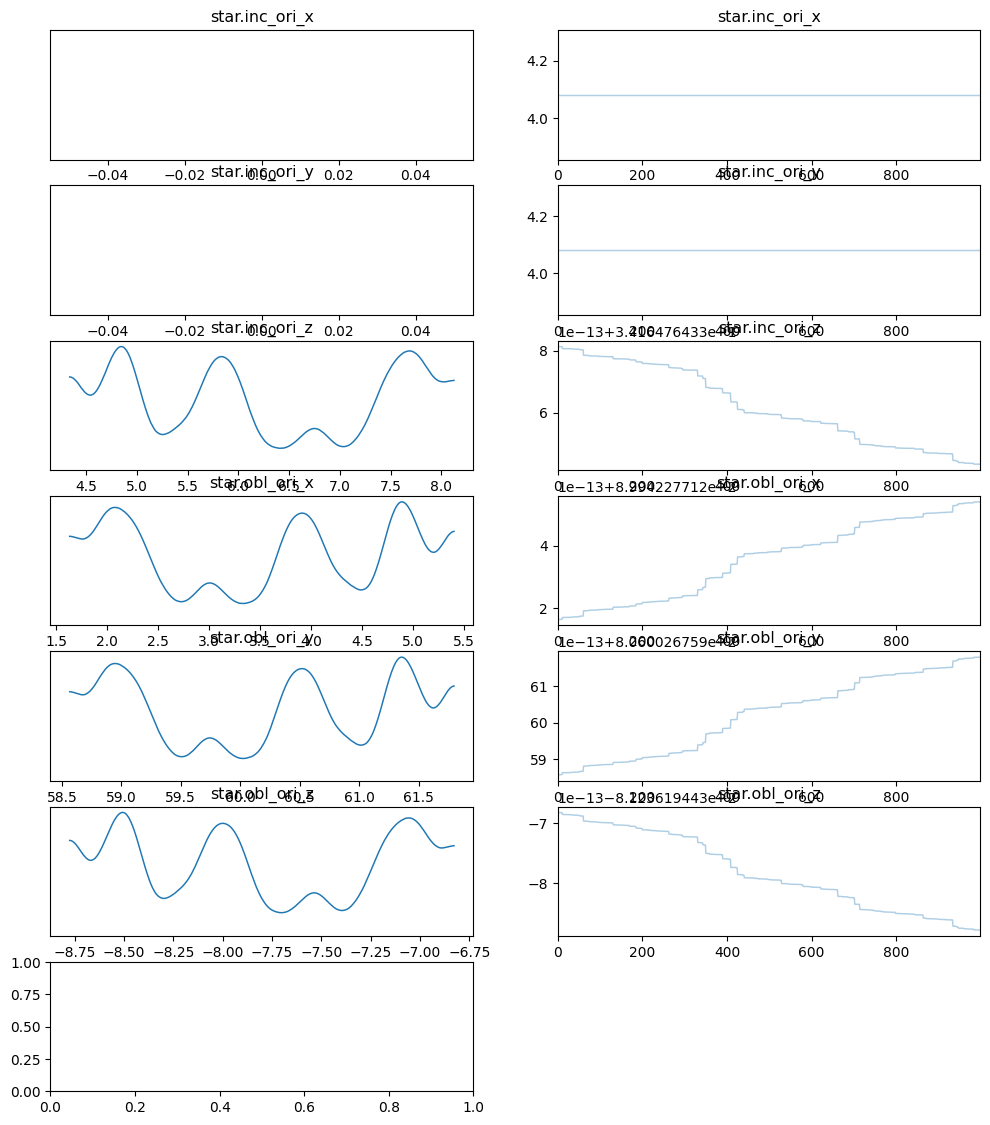

In [99]:
az.plot_trace(trace)